# Image Captioning

## Dataset configuration

**Importing necessary libraries**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torchvision.transforms as transforms

**Defining classes for image and captions dataloading**

In [70]:
# We want to convert text -> numerical values
# 1. We need a Vocabulary mapping each word to a index
# 2. We need to setup a Pytorch dataset to load the data
# 3. Setup padding of every batch (all examples should be
#    of same seq_len and setup dataloader)
# Note that loading the image is very easy compared to the text!

# Download with: python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")

#vocabulary is just a dictionary class that I got from stackoverflow to make life easier.
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# REFERENCE : https://www.kaggle.com/code/mdteach/torch-data-loader-flicker-8k
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx, batch_first):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    batch_first=True
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx, batch_first),
    )

    return loader, dataset


if __name__ == "__main__":
    transform = transforms.Compose(
        [transforms.Resize((224, 224)), transforms.ToTensor(),]
    )

    loader, dataset = get_loader(
        "/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/images", "/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/captions.txt", transform=transform
    )


## Encoder, Decoder and Bridge Models

**Defining models for encoder, decoder and their combination (bridge) for baseline and also with attention mechanism**

In [41]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN_Encoder(nn.Module) : 
    def __init__(self, embedding_len, trainConvNet = False) -> None:
        super(CNN_Encoder, self).__init__()
        self.trainConvNet = False # just using a pre trained CNN to save on some time.
        resnet = models.resnet50(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embedding_len)

        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = self.trainConvNet
    
    def forward(self, images) :
        out = self.resnet(images)
        out = out.view(out.size(0), -1)
        out = self.embed(out)
        return out
    
class RNN(nn.Module) : 
    def __init__(self, embedding_len, hidden_len, vocab_len, num_layers, dropout) :
        super(RNN,self).__init__()
        self.embed = nn.Embedding(vocab_len,embedding_len)
        self.lstm = nn.LSTM(embedding_len,hidden_len, num_layers,batch_first=True)
        self.linear = nn.Linear(hidden_len,vocab_len) #hidden len to vocab size which serves as indexing essentially
        self.dropout = nn.Dropout(dropout)
    def forward(self, features, captions):
        embeddings = self.embed(captions[:, :-1])
        #adding dropout post embedding layer is going to let go of certain indices and help prevent overfitting.
        embeddings = torch.cat((features.unsqueeze(1),embeddings),dim = 1)
        #Here the teacher forces all the correct captions inside as embeddings. 
        #We feed in all the correct ground truth to the rnn and later in eval we will just feed prev cell's output
        #but for now this will do well since it won't accidentally end up leaerning incorrect captions.
        #here we want to pass the feature vector from the CNN as the first embedding to our RNN.
        #So we take that feature and make if of the size (1,embeding_len) unsqueeze justs makes it from 
        #(embedding_len,) to (1,em) by adding a dimension of 1 at the 0th pos. Now we concat along row direction
        hiddens, _ = self.lstm(embeddings) #Pass the encoding through the linear layer to get outputs.
        outputs = self.linear(hiddens)
        return outputs
    
class Bridge(nn.Module):
    def __init__(self, embedding_len, hidden_len,vocab_len, num_layers, dropout) :
        super(Bridge,self).__init__()
        self.cnn_encoder = CNN_Encoder(embedding_len)
        self.rnn = RNN(embedding_len,hidden_len,vocab_len,num_layers,dropout)
    
    def forward(self, images, captions):
        features = self.cnn_encoder(images) #get image feature and pass to rnn.
        outputs = self.rnn(features,captions)
        return outputs
    
    def caption_image(self,image,vocabulary,max_len =50):
        captions = []
        #to return the captions.
        with torch.no_grad(): #unsqueeze for batch dimension
            x = self.cnn_encoder(image).unsqueeze(0) #start with input embedding as x -> image feature.
            states = None 
            for _ in range(max_len):
                #take the hidden layer and hidden state of lstm output and hiddens will have the encoding.
                #pass encoding through linear layer and get the prediction and hence word.
                hiddens, states = self.rnn.lstm(x,states)
                output = self.rnn.linear(hiddens)
                output = output.view(x.size(0), -1)
                predicted = output.argmax(dim=1)
                #Previous prediction x is passed in the next time step to the lstm.
                captions.append(predicted.item())
                x = self.rnn.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>" :
                    break
        return [vocabulary.itos[idx] for idx in captions]


    
class CNN_Encoder_Att(nn.Module) : 
    def __init__(self, trainConvNet = False) -> None:
        super(CNN_Encoder_Att, self).__init__()
        self.trainConvNet = False # just using a pre trained CNN to save on some time.
        resnet = models.resnet50(pretrained=True)  # pretrained ImageNet ResNet-101

        # Remove linear and pool layers (since we're not doing classification)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = self.trainConvNet
    
    def forward(self, images) :
        out = self.resnet(images)  # (batch_size, 2048, encoded_image_size, encoded_image_size)
        out = out.permute(0, 2, 3, 1)  # (batch_size, encoded_image_size, encoded_image_size, 2048)
        out = out.view(out.size(0), -1, out.size(-1))   # (batch_size, num_pixels, 2048)
        return out

class Attention(nn.Module) :
    def __init__(self, enc_dim, dec_dim, att_dim):
        super(Attention, self).__init__()
        self.enc_att = nn.Linear(enc_dim, att_dim)  # linear layer to transform encoded image
        self.dec_att = nn.Linear(dec_dim, att_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(att_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, features, dec_hid):
        encoder_att = self.enc_att(features)  # (batch_size, num_pixels, attention_dim)
        decoder_att = self.dec_att(dec_hid)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(encoder_att + decoder_att.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        att_weights = (features * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, enc_dim)

        return alpha, att_weights
    
class RNN_Att(nn.Module):
    def __init__(self, att_dim, embedding_len, dec_dim, vocab_len, enc_dim=2048, dropout=0.5):
        super(RNN_Att, self).__init__()

        self.vocab_len = vocab_len

        self.attention = Attention(enc_dim, dec_dim, att_dim)       # attention network
        self.embed = nn.Embedding(vocab_len, embedding_len)  # embedding layer
        self.dropout = nn.Dropout(dropout)
        self.lstm_cell = nn.LSTMCell(embedding_len + enc_dim, dec_dim, bias=True)  # decoding LSTMCell
        self.init_h = nn.Linear(enc_dim, dec_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(enc_dim, dec_dim)  # linear layer to find initial cell state of LSTMCell

        self.fc = nn.Linear(dec_dim, vocab_len)  # linear layer to find scores over vocabulary

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        h, c = self.init_hidden_state(features)

        cap_len = len(captions[0]) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)

        preds = torch.zeros(batch_size, cap_len, self.vocab_len).to(device)
        alphas = torch.zeros(batch_size, cap_len, num_features).to(device)

        for cap in range(cap_len):
            alpha, context = self.attention(features, h)
            # print(np.shape(embeddings[:, cap]), np.shape(context))
            lstm_in = torch.cat([embeddings[:, cap], context], dim=1)
            h, c = self.lstm_cell(lstm_in, (h, c))
            out = self.fc(self.dropout(h))

            preds[:, cap] = out
            alphas[:, cap] = alpha

        return preds, alphas

    def init_hidden_state(self, features):
        mean_features = features.mean(dim=1)
        h = self.init_h(mean_features)  # (batch_size, decoder_dim)
        c = self.init_c(mean_features)
        return h, c
    
class Bridge_Att(nn.Module):
    def __init__(self, embedding_len, vocab_len, att_dim, enc_dim, dec_dim) :
        super(Bridge_Att,self).__init__()
        self.cnn_encoder = CNN_Encoder_Att()
        self.rnn = RNN_Att(att_dim, embedding_len, dec_dim, vocab_len, enc_dim)

    def forward(self, images, captions):
        features = self.cnn_encoder(images) #get image feature and pass to rnn.
        outputs = self.rnn(features, captions)
        return outputs
    
    def caption_image(self,image, vocabulary, max_len=50):
        with torch.no_grad():
            features = self.cnn_encoder(image)

            batch_size = features.size(0)
            h, c = self.rnn.init_hidden_state(features)

            alphas = []
            captions = []

            #first input
            word = torch.tensor(vocabulary.stoi['<SOS>']).view(1,-1).to(device)
            embeddings = self.rnn.embed(word)

            for _ in range(max_len):
                alpha, context = self.rnn.attention(features, h)
                alphas.append(alpha.cpu().detach().numpy())
                
                lstm_in = torch.cat([embeddings[:, 0], context], dim=1)
                h, c = self.rnn.lstm_cell(lstm_in, (h, c))
                out = self.rnn.fc(self.rnn.dropout(h))

                out = out.view(batch_size, -1)
                predicted = out.argmax(dim=1)

                captions.append(predicted.item())
                #Previous prediction embeddings is passed in the next time step to the lstm.
                embeddings = self.rnn.embed(predicted.unsqueeze(0))

                if vocabulary.itos[predicted.item()] == "<EOS>" :
                    break
            return [vocabulary.itos[idx] for idx in captions], alphas



**Adding Reference sentences for test examples**

In [42]:
refsent1 = ["A girl and her horse stand by a fire .","A girl holding a horse 's lead behind a fire .","A man , and girl and two horses are near a contained fire .","Two people and two horses watching a fire ."]
refsent2 = ["A man fishes by a tree in the morning mist .","A man fishes under a large tree .","A man fishing near a large tree .","A man is fishing in a foggy lake ."]
refsent3 = ["a kayaker kayaks through the water .","A person kayaking in the ocean .","A person kayaks in the middle of the ocean on a grey day .","A person rows a boat over a large body of water .","person in a boat with a paddle in hand ."]
refsent4 = ["A man in a red jacket is sitting on a bench whilst cooking a meal .","A man sits on a bench .","A man is sitting on a bench , cooking some food .","A man wearing a red jacket is sitting on a wooden bench and is cooking something in a small pot .","a man wearing a red jacket sitting on a bench next to various camping items"]
refsent5 = ["A couple stands close at the water 's edge .","The two people stand by a body of water and in front of bushes in fall .","Two people hold each other near a pond .","Two people stand by the water .","Two people stand together on the edge of the water on the grass ."]

**Defining function for inference with test examples**

In [43]:
printouts = []
def print_examples(model, device, dataset):
    printouts.clear()
    transform = transforms.Compose(
        [
            transforms.Resize(224),
            # transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )

    model.eval()

    if(type(model)==Bridge_Att):
        test_img1 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/10815824_2997e03d76.jpg").convert("RGB")).unsqueeze(
            0
        )
        print("Example 1 CORRECT: A girl and her horse stand by a fire")
        out, _ = model.caption_image(test_img1.to(device), dataset.vocab)
        printouts.append(out)
        print(printouts)
        print(
            "Example 1 OUTPUT: "
            + " ".join(out)
        )
        test_img2 = transform(
            Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/17273391_55cfc7d3d4.jpg").convert("RGB")
        ).unsqueeze(0)
        print("Example 2 CORRECT: A man fishes under a large tree")
        out, _ = model.caption_image(test_img2.to(device), dataset.vocab)
        printouts.append(out)
        print(printouts)
        print(
            "Example 2 OUTPUT: "
            + " ".join(out)
        )
        test_img3 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/19212715_20476497a3.jpg").convert("RGB")).unsqueeze(
            0
        )
        print("Example 3 CORRECT: A person kayaking in the ocean")
        out, _ = model.caption_image(test_img3.to(device), dataset.vocab)
        printouts.append(out)
        print(
            "Example 3 OUTPUT: "
            + " ".join(out)
        )
        test_img4 = transform(
            Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/35506150_cbdb630f4f.jpg").convert("RGB")
        ).unsqueeze(0)
        print("Example 4 CORRECT: A man is sitting on a bench , cooking some food .")
        out, _ = model.caption_image(test_img4.to(device), dataset.vocab)
        printouts.append(out)
        print(
            "Example 4 OUTPUT: "
            + " ".join(out)
        )
        test_img5 = transform(
            Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/3637013_c675de7705.jpg").convert("RGB")
        ).unsqueeze(0)
        print("Example 5 CORRECT: Two people stand together on the edge of the water on the grass")
        out, _ = model.caption_image(test_img5.to(device), dataset.vocab)
        printouts.append(out)
        print(
            "Example 5 OUTPUT: "
            + " ".join(out)
        )
    else:
        test_img1 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/10815824_2997e03d76.jpg").convert("RGB")).unsqueeze(
            0
        )
        print("Example 1 CORRECT: A girl and her horse stand by a fire")
        out = model.caption_image(test_img1.to(device), dataset.vocab)
        printouts.append(out)
        print(printouts)
        print(
            "Example 1 OUTPUT: "
            + " ".join(out)
        )
        test_img2 = transform(
            Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/17273391_55cfc7d3d4.jpg").convert("RGB")
        ).unsqueeze(0)
        print("Example 2 CORRECT: A man fishes under a large tree")
        out = model.caption_image(test_img2.to(device), dataset.vocab)
        printouts.append(out)
        print(printouts)
        print(
            "Example 2 OUTPUT: "
            + " ".join(out)
        )
        test_img3 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/19212715_20476497a3.jpg").convert("RGB")).unsqueeze(
            0
        )
        print("Example 3 CORRECT: A person kayaking in the ocean")
        out = model.caption_image(test_img3.to(device), dataset.vocab)
        printouts.append(out)
        print(
            "Example 3 OUTPUT: "
            + " ".join(out)
        )
        test_img4 = transform(
            Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/35506150_cbdb630f4f.jpg").convert("RGB")
        ).unsqueeze(0)
        print("Example 4 CORRECT: A man is sitting on a bench , cooking some food .")
        out = model.caption_image(test_img4.to(device), dataset.vocab)
        printouts.append(out)
        print(
            "Example 4 OUTPUT: "
            + " ".join(out)
        )
        test_img5 = transform(
            Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/3637013_c675de7705.jpg").convert("RGB")
        ).unsqueeze(0)
        print("Example 5 CORRECT: Two people stand together on the edge of the water on the grass")
        out = model.caption_image(test_img5.to(device), dataset.vocab)
        printouts.append(out)
        print(
            "Example 5 OUTPUT: "
            + " ".join(out)
        )

## Training and Inference

**Training loop for baseline model**

In [6]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("!!!!Saving checkpoint!!!!")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("!!!!Loading checkpoint!!!!")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

def train():
    transform = transforms.Compose(
        [
            transforms.Resize(226),
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/images",
        annotation_file="/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
        batch_first=True
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    load_model = True
    save_model = False
    trainConvnet = False

    # Hyperparameters
    embedding_len = 400
    hidden_len = 512
    vocab_len = len(dataset.vocab)
    num_layers = 2
    learning_rate = 3e-4
    num_epochs = 1

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = Bridge(embedding_len, hidden_len, vocab_len, num_layers, 0.5).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.cnn_encoder.resnet.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = trainConvnet

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)
        print("Done")
        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            # print(np.shape(imgs))
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions)
            loss = criterion(
                outputs.view(-1, outputs.shape[2]), captions.view(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

if __name__ == "__main__":
    train()

cuda


/home/sony-r301/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sony-r301/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


!!!!Loading checkpoint!!!!
Done


**Baseline Model with loaded weights for inference**

In [49]:
embedding_len = 400
hidden_len = 512
vocab_len = len(dataset.vocab)
num_layers = 2
learning_rate = 3e-4
model = Bridge(embedding_len, hidden_len, vocab_len, num_layers, 0.5).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

/home/sony-r301/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sony-r301/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


!!!!Loading checkpoint!!!!


251735

**Inference with example images**

In [50]:
print_examples(model, device, dataset)

Example 1 CORRECT: A girl and her horse stand by a fire
[['<SOS>', 'a', 'girl', 'and', 'her', 'horse', 'stand', 'by', 'a', 'fire', '.', '<EOS>']]
Example 1 OUTPUT: <SOS> a girl and her horse stand by a fire . <EOS>
Example 2 CORRECT: A man fishes under a large tree
[['<SOS>', 'a', 'girl', 'and', 'her', 'horse', 'stand', 'by', 'a', 'fire', '.', '<EOS>'], ['<SOS>', 'a', 'man', 'fishes', 'under', 'a', 'large', 'tree', '.', '<EOS>']]
Example 2 OUTPUT: <SOS> a man fishes under a large tree . <EOS>
Example 3 CORRECT: A person kayaking in the ocean
Example 3 OUTPUT: <SOS> a person kayaks in the middle of the ocean on a grey day . <EOS>
Example 4 CORRECT: A man is sitting on a bench , cooking some food .
Example 4 OUTPUT: <SOS> a man is sitting on a bench and reading a book . <EOS>
Example 5 CORRECT: Two people stand together on the edge of the water on the grass
Example 5 OUTPUT: <SOS> two people stand by the water . <EOS>


**Training loop for modified model (with attention)**

In [9]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
def save_checkpoint(state, filename="my_checkpoint_att.pth.tar"):
    print("!!!!Saving checkpoint!!!!")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("!!!!Loading checkpoint!!!!")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

def train():
    transform = transforms.Compose(
        [
            transforms.Resize(226),
            transforms.RandomCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder="/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/images",
        annotation_file="/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/captions.txt",
        transform=transform,
        num_workers=2,
        batch_first=True
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    load_model = True
    save_model = False
    trainConvnet = False

    # Hyperparameters
    embedding_len = 256
    vocab_len = len(dataset.vocab)
    att_dim=256
    enc_dim=2048
    dec_dim=512
    learning_rate = 3e-4
    num_epochs = 1

    # for tensorboard
    writer = SummaryWriter("runs/flickr")
    step = 0

    # initialize model, loss etc
    model = Bridge_Att(embedding_len, vocab_len, att_dim, enc_dim, dec_dim).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.cnn_encoder.resnet.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = trainConvnet

    if load_model:
        step = load_checkpoint(torch.load("my_checkpoint_att.pth.tar"), model, optimizer)

    model.train()

    for epoch in range(num_epochs):
        # Uncomment the line below to see a couple of test cases
        # print_examples(model, device, dataset)

        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)
        print("Done")
        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            # print(np.shape(imgs))
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs, attentions = model(imgs, captions)
            loss = criterion(
                outputs.view(-1, vocab_len), captions[:,1:].reshape(-1)
            )

            writer.add_scalar("Training loss", loss.item(), global_step=step)
            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

if __name__ == "__main__":
    train()

cuda


/home/sony-r301/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sony-r301/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


!!!!Loading checkpoint!!!!
Done


**Modified Model with loaded weights for inference**

In [51]:
embedding_len = 256
vocab_len = len(dataset.vocab)
att_dim=256
enc_dim=2048
dec_dim=512
learning_rate = 3e-4
model_att = Bridge_Att(embedding_len, vocab_len, att_dim, enc_dim, dec_dim).to(device)
optimizer_att = optim.Adam(model_att.parameters(), lr=learning_rate)
load_checkpoint(torch.load("my_checkpoint_att.pth.tar"), model_att, optimizer_att)

!!!!Loading checkpoint!!!!


503470

**Inference with example images**

In [52]:
print_examples(model_att, device, dataset)

Example 1 CORRECT: A girl and her horse stand by a fire
[['a', 'girl', 'in', 'a', 'brown', 'shirt', 'is', 'playing', 'with', 'a', 'fire', '.', '<EOS>']]
Example 1 OUTPUT: a girl in a brown shirt is playing with a fire . <EOS>
Example 2 CORRECT: A man fishes under a large tree
[['a', 'girl', 'in', 'a', 'brown', 'shirt', 'is', 'playing', 'with', 'a', 'fire', '.', '<EOS>'], ['a', 'man', 'fishes', 'under', 'a', 'large', 'tree', '.', '<EOS>']]
Example 2 OUTPUT: a man fishes under a large tree . <EOS>
Example 3 CORRECT: A person kayaking in the ocean
Example 3 OUTPUT: a person kayaks in the middle of the ocean . <EOS>
Example 4 CORRECT: A man is sitting on a bench , cooking some food .
Example 4 OUTPUT: a man wearing a red jacket is sitting on a bench . <EOS>
Example 5 CORRECT: Two people stand together on the edge of the water on the grass
Example 5 OUTPUT: a man is rowing a canoe in a river . <EOS>


## Scoring (BLEU-4 and METEOR)

In [44]:
import nltk
nltk.download('punkt')
nltk.download('corpora')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate import meteor_score

[nltk_data] Downloading package punkt to /home/sony-r301/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Error loading corpora: Package 'corpora' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sony-r301/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sony-r301/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/sony-r301/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**Without Attention**

In [53]:
print_examples(model, device, dataset)

Example 1 CORRECT: A girl and her horse stand by a fire
[['<SOS>', 'a', 'girl', 'and', 'her', 'horse', 'stand', 'by', 'a', 'fire', '.', '<EOS>']]
Example 1 OUTPUT: <SOS> a girl and her horse stand by a fire . <EOS>
Example 2 CORRECT: A man fishes under a large tree
[['<SOS>', 'a', 'girl', 'and', 'her', 'horse', 'stand', 'by', 'a', 'fire', '.', '<EOS>'], ['<SOS>', 'a', 'man', 'fishes', 'under', 'a', 'large', 'tree', '.', '<EOS>']]
Example 2 OUTPUT: <SOS> a man fishes under a large tree . <EOS>
Example 3 CORRECT: A person kayaking in the ocean
Example 3 OUTPUT: <SOS> a person kayaks in the middle of the ocean on a grey day . <EOS>
Example 4 CORRECT: A man is sitting on a bench , cooking some food .
Example 4 OUTPUT: <SOS> a man is sitting on a bench and reading a book . <EOS>
Example 5 CORRECT: Two people stand together on the edge of the water on the grass
Example 5 OUTPUT: <SOS> two people stand by the water . <EOS>


In [54]:
candidate_sentencelist = printouts
reference_sentenceslist = [refsent1,refsent2,refsent3,refsent4,refsent5]

for i in range(5):
    print("example: ",i+1)
    candidate_sentence = candidate_sentencelist[i]
    reference_sentences = reference_sentenceslist[i]

    candidate_tokens = candidate_sentence

    reference_tokens = []
    for sentence in reference_sentences:
        reference_tokens.append(nltk.word_tokenize(sentence.lower()))




    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    print("BLEU-4 score:", bleu_score)

    score = meteor_score.meteor_score(reference_tokens, candidate_tokens)
    print("METEOR score:", score,"\n\n")

example:  1
BLEU-4 score: 0.8070557274927982
METEOR score: 0.9799019607843138 


example:  2
BLEU-4 score: 0.7598356856515925
METEOR score: 0.9746570121951219 


example:  3
BLEU-4 score: 0.861173529963367
METEOR score: 0.985735843633228 


example:  4
BLEU-4 score: 0.4574563333993253
METEOR score: 0.6228465412138882 


example:  5
BLEU-4 score: 0.7259795291154771
METEOR score: 0.9708049886621315 




**With attention**

In [55]:
print_examples(model_att, device, dataset)

Example 1 CORRECT: A girl and her horse stand by a fire
[['a', 'girl', 'in', 'a', 'brown', 'shirt', 'is', 'playing', 'with', 'a', 'fire', '.', '<EOS>']]
Example 1 OUTPUT: a girl in a brown shirt is playing with a fire . <EOS>
Example 2 CORRECT: A man fishes under a large tree
[['a', 'girl', 'in', 'a', 'brown', 'shirt', 'is', 'playing', 'with', 'a', 'fire', '.', '<EOS>'], ['a', 'man', 'fishes', 'under', 'a', 'large', 'tree', '.', '<EOS>']]
Example 2 OUTPUT: a man fishes under a large tree . <EOS>
Example 3 CORRECT: A person kayaking in the ocean
Example 3 OUTPUT: a person kayaks in the middle of the ocean . <EOS>
Example 4 CORRECT: A man is sitting on a bench , cooking some food .
Example 4 OUTPUT: a man wearing a red jacket is sitting on a bench . <EOS>
Example 5 CORRECT: Two people stand together on the edge of the water on the grass
Example 5 OUTPUT: a man is rowing a canoe in a river . <EOS>


In [56]:
candidate_sentencelist = printouts
reference_sentenceslist = [refsent1,refsent2,refsent3,refsent4,refsent5]

for i in range(5):
    print("example: ",i+1)
    candidate_sentence = candidate_sentencelist[i]
    reference_sentences = reference_sentenceslist[i]

    candidate_tokens = candidate_sentence

    reference_tokens = []
    for sentence in reference_sentences:
        reference_tokens.append(nltk.word_tokenize(sentence.lower()))




    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25))
    print("BLEU-4 score:", bleu_score)

    score = meteor_score.meteor_score(reference_tokens, candidate_tokens)
    print("METEOR score:", score,"\n\n")

example:  1
BLEU-4 score: 3.6192421858902592e-78
METEOR score: 0.5022321428571428 


example:  2
BLEU-4 score: 0.8633400213704505
METEOR score: 0.9866898148148149 


example:  3
BLEU-4 score: 0.8593887047640296
METEOR score: 0.9349145063430778 


example:  4
BLEU-4 score: 0.912167909070388
METEOR score: 0.8848012889366274 


example:  5
BLEU-4 score: 1.3165594234639305e-231
METEOR score: 0.10869565217391303 




/home/sony-r301/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/sony-r301/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/sony-r301/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use S

**Functions for obtaining image plots along with attention**

In [74]:
import matplotlib.pyplot as plt
def show_image(img, title=None):

    img = img.numpy().transpose((1, 2, 0))
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def get_captions_att(image):
    #generate the caption
    model_att.eval()
    with torch.no_grad():
        caps, alphas = model_att.caption_image(image.to(device), dataset.vocab)
        caption = ' '.join(caps)
        show_image(image[0],title=caption)
    return caps,alphas

def get_captions(image):
    #generate the caption
    model.eval()
    with torch.no_grad():
        caps = model.caption_image(image.to(device), dataset.vocab)
        caption = ' '.join(caps)
        show_image(image[0],title=caption)
    return caps

#Show attention
def plot_attention(img, result, attention_plot):

    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        # print(np.shape(attention_plot[l]))
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [61]:
import copy

## Visualizing Attention

**Plotting images with attention**

In [65]:
# transform = transforms.Compose(
#         [
#             transforms.Resize(224),
#             # transforms.RandomCrop(224),
#             transforms.ToTensor(),
#             transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
#         ]
#     )

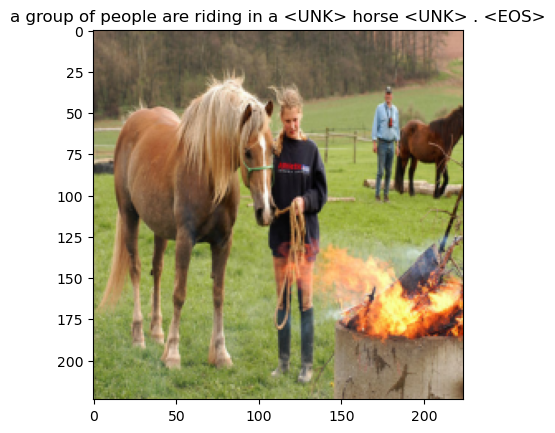

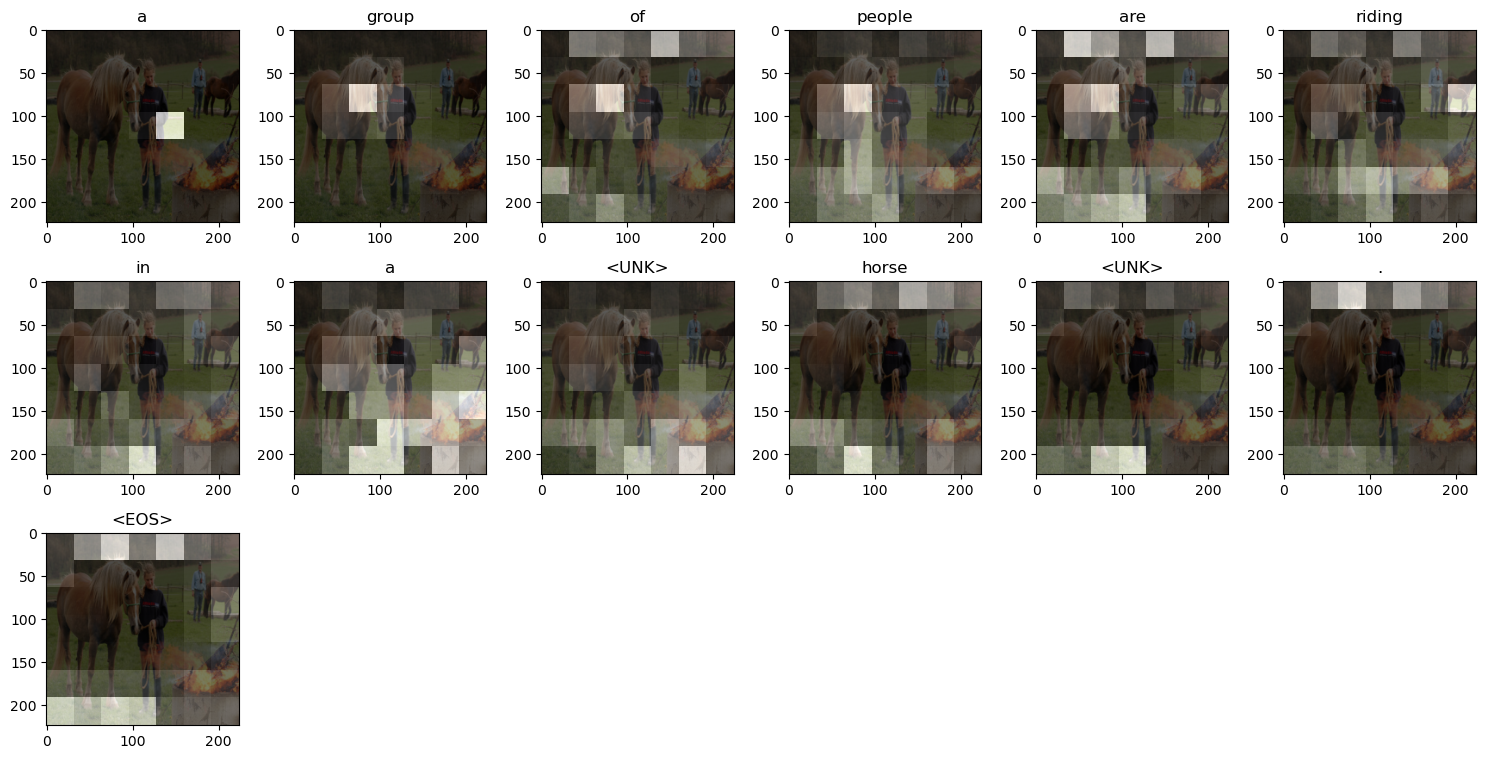

In [75]:
test_img1 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/10815824_2997e03d76.jpg").convert("RGB"))
img1 = copy.deepcopy(test_img1)
capsatt, alphas = get_captions_att(test_img1.unsqueeze(0))

plot_attention(img1, capsatt, alphas)

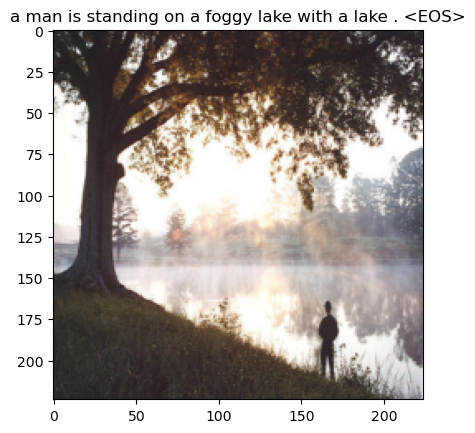

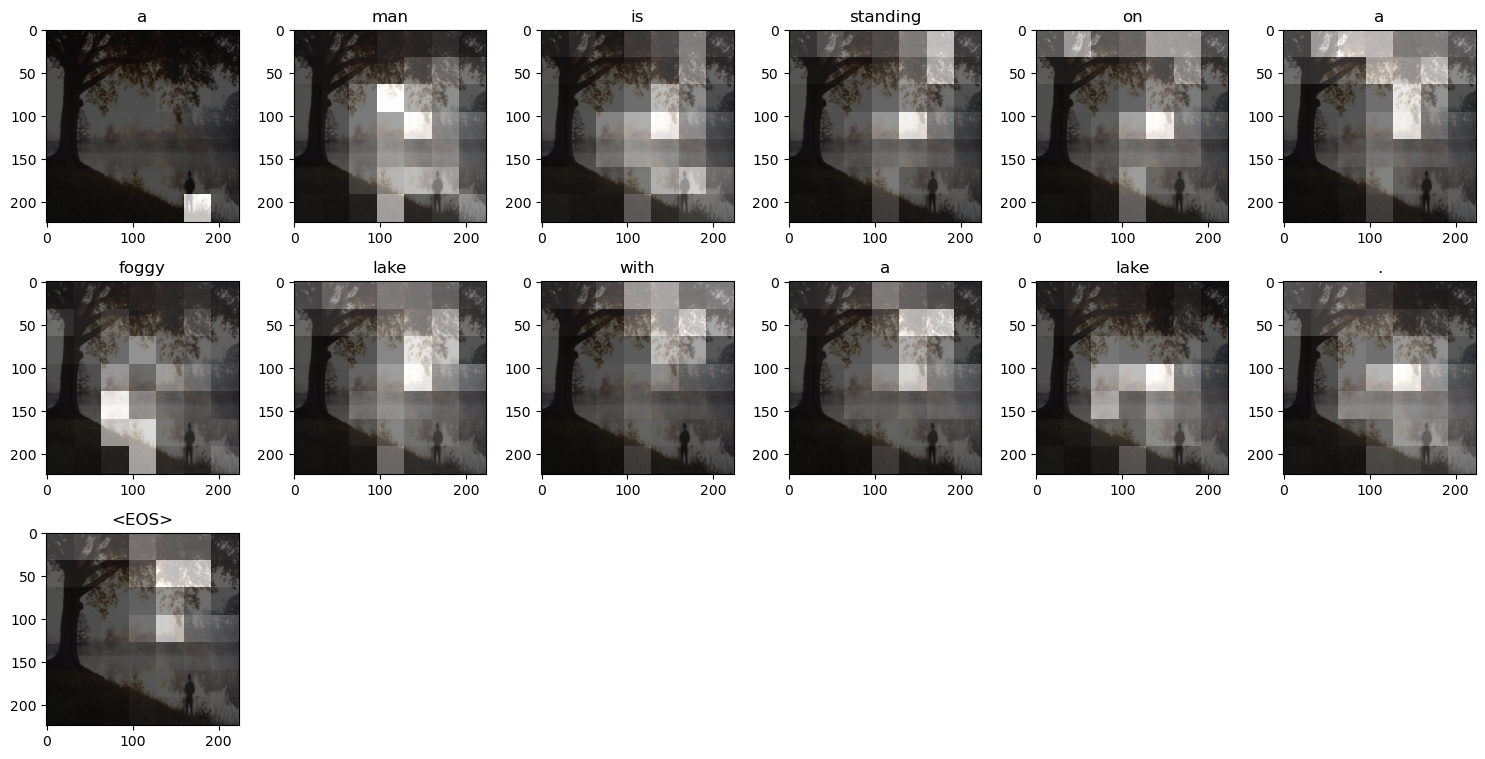

In [76]:
test_img1 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/17273391_55cfc7d3d4.jpg").convert("RGB"))
img1 = copy.deepcopy(test_img1)
capsatt, alphas = get_captions_att(test_img1.unsqueeze(0))

plot_attention(img1, capsatt, alphas)

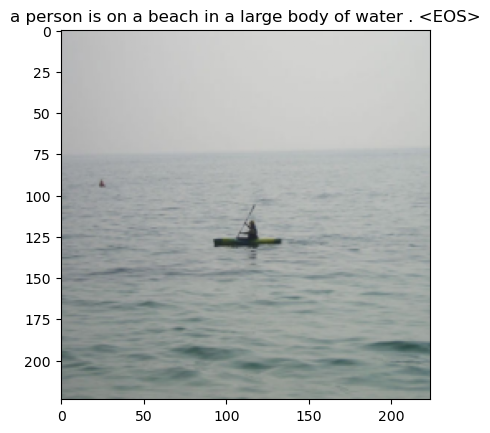

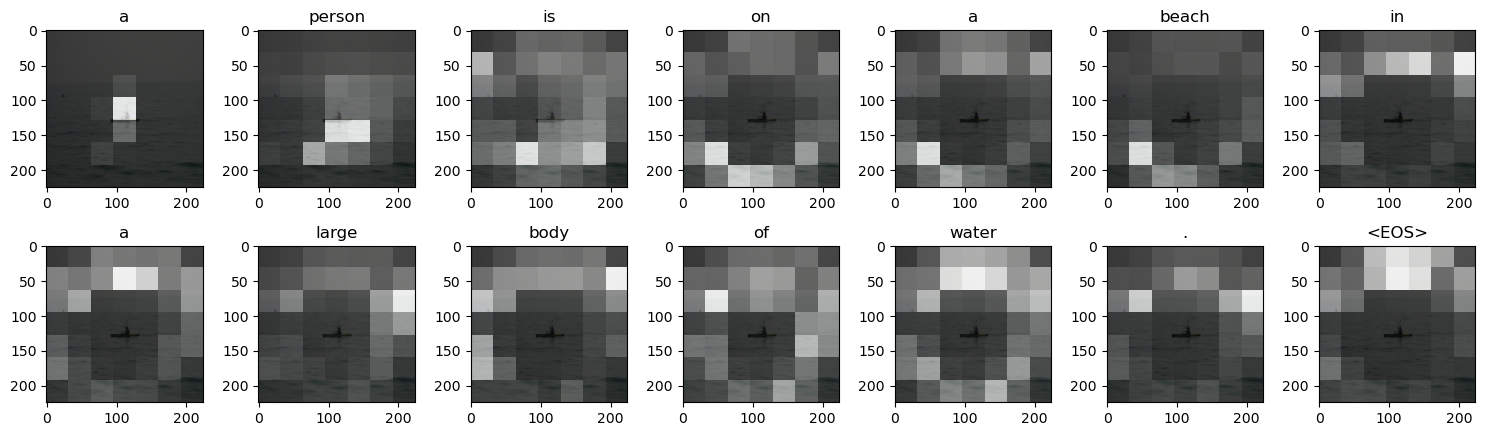

In [77]:
test_img1 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/19212715_20476497a3.jpg").convert("RGB"))
img1 = copy.deepcopy(test_img1)
capsatt, alphas = get_captions_att(test_img1.unsqueeze(0))

plot_attention(img1, capsatt, alphas)

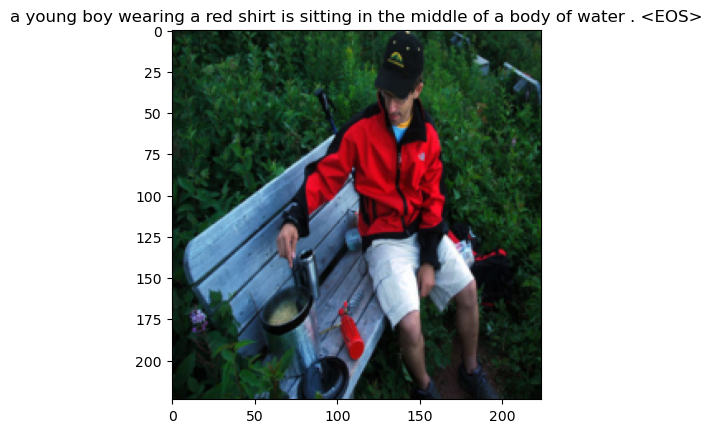

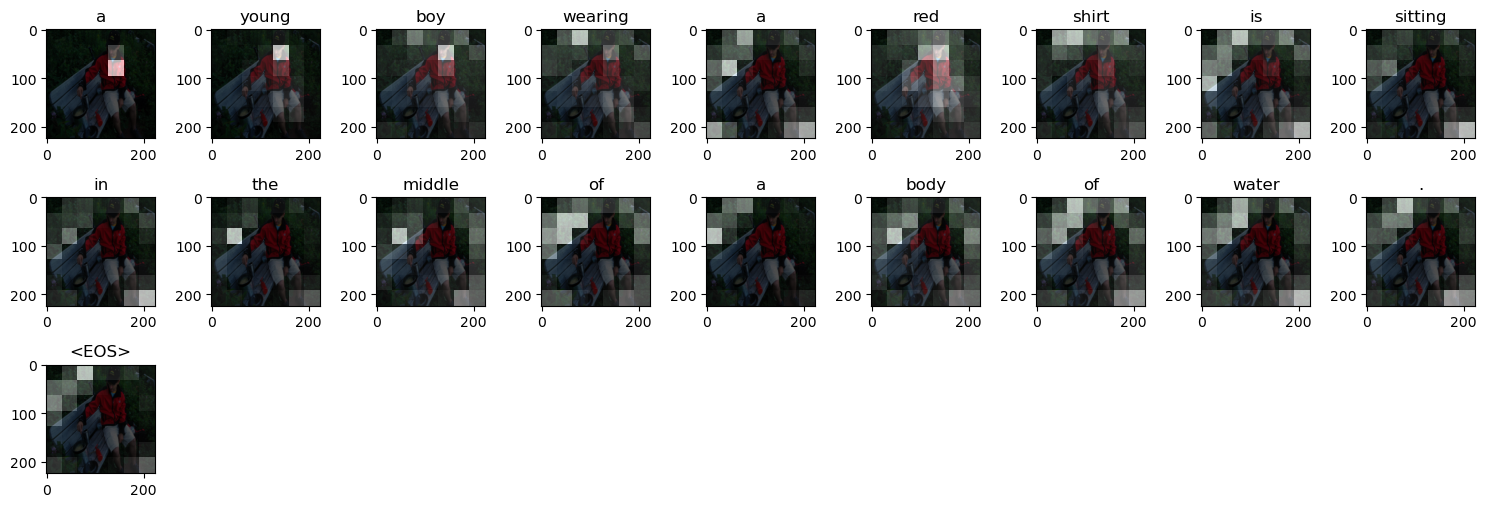

In [78]:
test_img1 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/35506150_cbdb630f4f.jpg").convert("RGB"))
img1 = copy.deepcopy(test_img1)
capsatt, alphas = get_captions_att(test_img1.unsqueeze(0))

plot_attention(img1, capsatt, alphas)

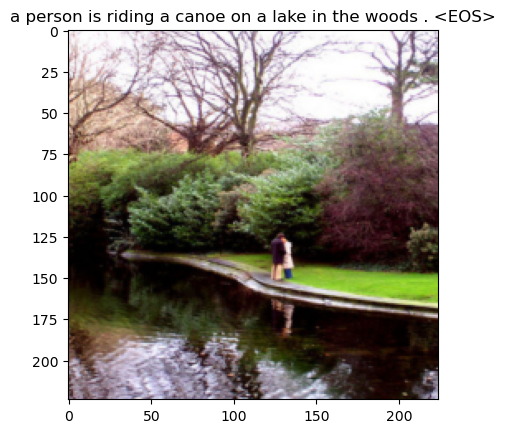

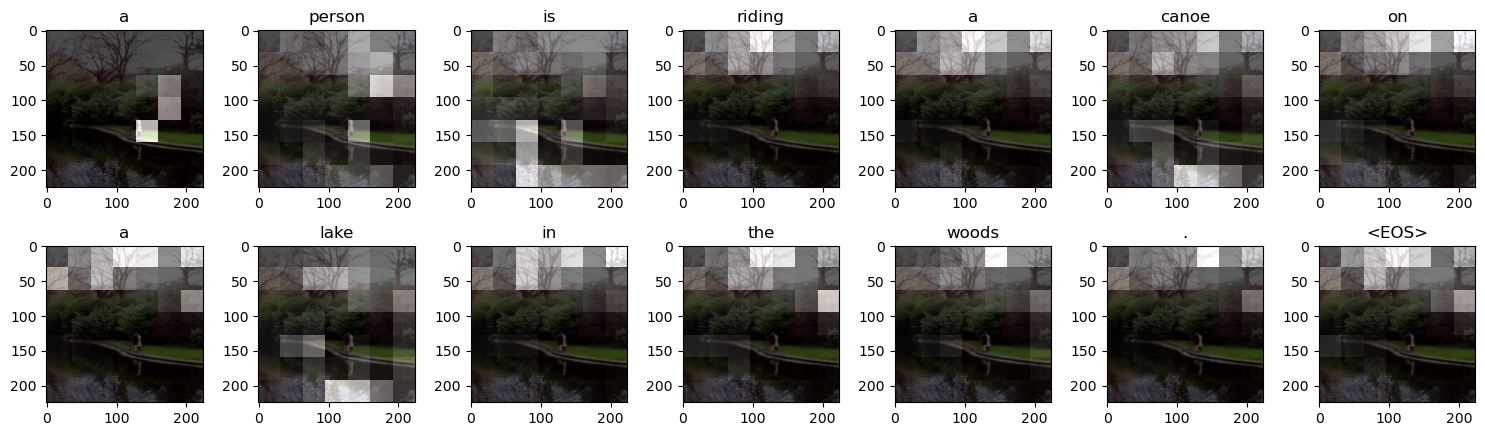

In [79]:
test_img1 = transform(Image.open("/home/sony-r301/ImageCaptioning/ImageCaptioning/flickr8k/ti/3637013_c675de7705.jpg").convert("RGB"))
img1 = copy.deepcopy(test_img1)
capsatt, alphas = get_captions_att(test_img1.unsqueeze(0))

plot_attention(img1, capsatt, alphas)